# Numerical Kludge (NK) Waveform Debugger

这个 Notebook 用于测试 NK 波形计算模块。它模拟了以下流程：
1. 生成一个模拟的轨道 CSV 文件 (t, r, theta, phi)。
2. 从 CSV 读取数据。
3. 调用 `nk_calculator.py` 计算引力波应变 $h_+$ 和 $h_\times$。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quadrupole_octupole import calculate_nk_waveform_from_arrays, ObserverInfo, G_SI, C_SI, M_SUN_SI, PC_SI

%matplotlib inline

## 1. 生成测试数据 (CSV)

这里我们生成一个简单的绝热 inspiral 轨道 (类 Schwarzschild 圆轨道 + 缓慢缩小)。
注意：
- 时间 $t$ 是以 $M$ 为单位。
- 距离 $r$ 是以 $M$ 为单位。

In [ ]:
# # 参数设置
# dt_M = 1.0            # 时间步长 (M)
# duration_M = 20000.0   # 总时长 (M)
# t_arr = np.arange(0, duration_M, dt_M)

# # 模拟轨道: 半径从 12M 缩减到 11M，简单的轨道频率
# r0 = 12.0
# r_arr = np.linspace(r0, 11.0, len(t_arr))

# # Keplerian frequency (approx): Omega = r^(-3/2)
# phase = np.cumsum(r_arr**(-1.5) * dt_M)
# phi_arr = phase % (2 * np.pi)

# # 设为赤道面轨道 (theta = pi/2)
# theta_arr = np.ones_like(t_arr) * (np.pi / 2.0)

# # 保存为 CSV
# df = pd.DataFrame({
#     't': t_arr,
#     'r': r_arr,
#     'theta': theta_arr,
#     'phi': phi_arr
# })

# csv_filename = '0.csv'
# df.to_csv(csv_filename, index=False)
# print(f"已生成测试文件: {csv_filename}, 数据点数: {len(df)}")

## 2. 读取 CSV 并配置物理参数

在此步骤，你需要设置真实的物理质量和观测距离，因为波形的振幅需要物理单位。

In [9]:
# 读取 CSV
import pandas as pd
import numpy as np

# 1. 读取 CSV，不带表头
# names 参数手动指定列名，方便后续调用
df = pd.read_csv('0.csv', header=None, names=['t', 'r', 'phi'])

# 2. 检查一下数据情况 (可选)
print(f"读取行数: {len(df)}")
print(df.head())

# 3. 补全缺失的 theta 列
# 如果是赤道面轨道，theta 恒等于 pi/2 (90度)
df['theta'] = np.pi / 2.0

# 4. 重新调整列顺序以符合你的 NK 代码预期: t, r, theta, phi
df = df[['t', 'r', 'theta', 'phi']]

# 5. 转换为 numpy 数组供计算函数使用
data_array = df.to_numpy()

print("\n补全后的前5行 (t, r, theta, phi):")
print(data_array[:5])
#data = pd.read_csv(df)
t_M_in = df['t'].values
r_M_in = df['r'].values
theta_in = df['theta'].values
phi_in = df['phi'].values

# 设置物理参数
M_bh = 1e6       # 主黑洞质量 (Solar Masses)
mu_obj = 10.0    # 小天体质量 (Solar Masses)
dist_pc = 1e9    # 观测距离 1 Gpc (Parsecs)
dist_m = dist_pc * PC_SI # 转换为米

# 设置观测角度 (观测者在天球上的位置)
obs_theta = np.pi / 4  # 45度
obs_phi = 0.0

observer = ObserverInfo(R=dist_m, theta=obs_theta, phi=obs_phi)

print("参数配置完成。")
print(f"Mass Ratio q = {mu_obj/M_bh}")
print(len(t_M_in), "个时间点准备计算波形。")

读取行数: 4001
          t         r       phi
0  0.000000  4.653834  0.000000
1  1.727413  4.657563  0.179974
2  3.452745  4.668773  0.359373
3  5.173940  4.687531  0.537626
4  6.888985  4.713944  0.714170

补全后的前5行 (t, r, theta, phi):
[[0.         4.65383435 1.57079633 0.        ]
 [1.72741272 4.65756342 1.57079633 0.17997448]
 [3.45274538 4.66877342 1.57079633 0.35937329]
 [5.17394035 4.68753126 1.57079633 0.53762559]
 [6.88898511 4.71394374 1.57079633 0.71417038]]
参数配置完成。
Mass Ratio q = 1e-05
4001 个时间点准备计算波形。


## 3. 计算波形

调用 `nk_calculator` 中的函数。

In [10]:
h_plus, h_cross = calculate_nk_waveform_from_arrays(
    t_M=t_M_in,
    r_M=r_M_in,
    theta=theta_in,
    phi=phi_in,
    M_phys=M_bh,
    mu_phys=mu_obj,
    observer=observer
)

# 为了绘图，将时间转换为秒
T_geom = G_SI * (M_bh * M_SUN_SI) / (C_SI**3)
t_seconds = t_M_in * T_geom

print("计算完成。")

计算完成。


## 4. 绘图结果

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2196832/1966745787.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.title(f'NK Waveform (Start) M={M_bh:.0e} $M_\odot$')


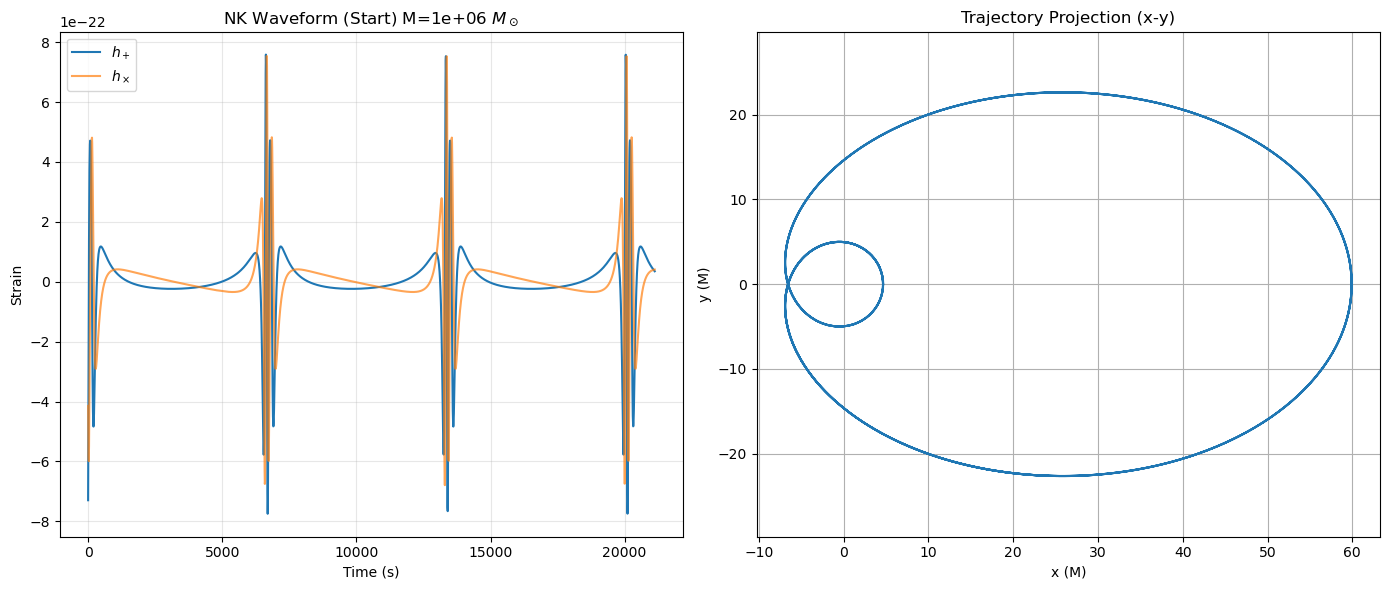

In [ ]:
plt.figure(figsize=(14, 6))

# 绘制波形 (取最后一段展示细节)
plot_idx = slice(0, 4000) # 前4000个点

plt.subplot(1, 2, 1)
plt.plot(t_seconds[plot_idx], h_plus[plot_idx], label='$h_+$', color='tab:blue')
plt.plot(t_seconds[plot_idx], h_cross[plot_idx], label='$h_\\times$', color='tab:orange', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title(f'NK Waveform (Start) M={M_bh:.0e} $M_\odot$')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
x = r_M_in * np.sin(theta_in) * np.cos(phi_in)
y = r_M_in * np.sin(theta_in) * np.sin(phi_in)
plt.plot(x[plot_idx], y[plot_idx])
plt.xlabel('x (M)')
plt.ylabel('y (M)')
plt.axis('equal')
plt.title('Trajectory Projection (x-y)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

def get_lisa_psd(f, include_confusion_noise=True, mission_duration_years=4.0):
    """
    计算 LISA 的功率谱密度 (PSD) S_n(f)。
    基于 Robson, Cornish, & Liu (2019) Class. Quantum Grav. 36 105011
    
    参数:
    -----
    f : np.ndarray
        频率数组 (Hz).
    include_confusion_noise : bool
        是否包含银河系致密双星背景噪声 (Confusion Noise)。
    mission_duration_years : float
        任务时长 (年)，用于计算 Confusion Noise 的平滑程度。
        
    返回:
    -----
    Sn : np.ndarray
        LISA 的噪声 PSD (1/Hz)。
    """
    # === 1. 基础常数 ===
    L = 2.5e9  # 臂长 (meter)
    c = 299792458.0
    f_star = c / (2.0 * np.pi * L) # 传输频率 ~ 19.09 mHz

    # === 2. 仪器噪声 (Instrumental Noise) ===
    # 光学计量噪声 (Optical Metrology System noise)
    # P_OMS 单位: m^2/Hz
    P_OMS = (1.5e-11)**2 * (1.0 + (2.0e-3 / f)**4)
    
    # 加速度计噪声 (Acceleration noise)
    # P_acc 单位: (m/s^2)^2/Hz -> 转换为位移噪声需除以 (2 pi f)^4
    P_acc = (3.0e-15)**2 * (1.0 + (0.4e-3 / f)**2) * (1.0 + (f / 8.0e-3)**4)
    
    # 将加速度噪声转换为位移噪声项
    P_acc_disp = P_acc / (2.0 * np.pi * f)**4
    
    # 仪器总噪声 PSD (单臂)
    # 因子 10/3 包含了三臂构型和天空平均响应 (Sky Averaging)
    # 这一项对应文献中的 S_n(f)
    Sn_instr = (10.0 / (3.0 * L**2)) * (P_OMS + 4.0 * P_acc_disp) * (1.0 + 0.6 * (f / f_star)**2)

    if not include_confusion_noise:
        return Sn_instr

    # === 3. 银河系前景噪声 (Galactic Confusion Noise) ===
    # 同样来自 Robson et al. 2019 Eq. 14
    # 这是一个经验拟合公式
    
    A = 9.0e-45
    alpha = 0.138
    beta = -221.0
    kappa = 521.0
    gamma = 1680.0
    f_k = 0.00113
    
    # 根据观测时长调整“拐点”
    if mission_duration_years <= 2.0:
        # Parameters for 2 years (approx) if needed, 
        # but Robson provides specific params. Here use the generic form adjustment if implied.
        # usually the fit is fixed for 4 years in standard codes. 
        # Let's stick to the 4-year standard curve which is most common.
        pass 
        
    # Standard 4-year fit
    Sc = A * np.exp(-(f**alpha) + beta * f * np.sin(kappa * f)) * \
         (1.0 + np.tanh(gamma * (f_k - f)))

    # 总噪声 = 仪器噪声 + 前景噪声
    return Sn_instr + Sc

def compute_mismatch(h1, h2, f_samp, f_min=1e-5, f_max=None, optimize_phase=True):
    """
    计算两个时域波形 h1 和 h2 的 Mismatch。
    Mismatch = 1 - Overlap
    
    Overlap = <h1|h2> / sqrt(<h1|h1> * <h2|h2>)
    
    参数:
    -----
    h1, h2 : np.ndarray
        时域波形数组 (Strain)。长度必须相等。
    f_samp : float
        采样率 (Hz)。
    f_min : float
        积分下限频率 (Hz)。LISA 通常取 1e-5 或 1e-4。
    f_max : float
        积分上限频率 (Hz)。默认取 Nyquist 频率。
    optimize_phase : bool
        是否对相位常数进行优化 (maximize over phase)。
        对于引力波物理，通常关心的是形状匹配，设为 True。
    
    返回:
    -----
    mismatch : float
        数值越小越好 (0 表示完全匹配)。
    """
    # 1. 检查长度
    n = len(h1)
    if len(h2) != n:
        raise ValueError(f"波形长度不一致: len(h1)={len(h1)}, len(h2)={len(h2)}")
    
    # 2. 预处理：加窗 (Tukey Window) 防止频谱泄漏
    # alpha=0.1 表示只有两端 5% 的数据被压制，中间保持不变
    window = windows.tukey(n, alpha=0.1)
    h1_w = h1 * window
    h2_w = h2 * window
    
    # 3. FFT 变换
    dt = 1.0 / f_samp
    hf1 = np.fft.rfft(h1_w) * dt  # 乘以 dt 以获得物理单位的傅里叶变换 (~ Strain * sec)
    hf2 = np.fft.rfft(h2_w) * dt
    freqs = np.fft.rfftfreq(n, d=dt)
    
    # 4. 频率截断与 PSD 计算
    if f_max is None:
        f_max = freqs[-1]
        
    # 创建掩码选择有效频段 [f_min, f_max]
    # 注意：必须排除 f=0 (DC分量)，因为 PSD 在 f=0 处发散
    mask = (freqs > f_min) & (freqs <= f_max)
    
    f_valid = freqs[mask]
    hf1_valid = hf1[mask]
    hf2_valid = hf2[mask]
    
    # 获取噪声 PSD
    Sn = get_lisa_psd(f_valid, include_confusion_noise=True)
    
    # 5. 定义内积函数
    # <a|b> = 4 * Re [ integral (a(f) * b*(f) / Sn(f)) df ]
    df = f_valid[1] - f_valid[0] # 频率分辨率
    
    def inner_product(a, b, psd):
        integrand = (a * np.conj(b)) / psd
        return 4.0 * np.sum(np.real(integrand)) * df

    def inner_product_complex(a, b, psd):
        """返回复数内积，用于相位最大化"""
        integrand = (a * np.conj(b)) / psd
        return 4.0 * np.sum(integrand) * df

    # 6. 计算模长 (Norm)
    norm1_sq = inner_product(hf1_valid, hf1_valid, Sn)
    norm2_sq = inner_product(hf2_valid, hf2_valid, Sn)
    
    norm1 = np.sqrt(norm1_sq)
    norm2 = np.sqrt(norm2_sq)
    
    # 7. 计算重叠度 (Overlap)
    ip_complex = inner_product_complex(hf1_valid, hf2_valid, Sn)
    
    if optimize_phase:
        # 如果优化相位，Overlap = |<h1|h2>| / (norm1 * norm2)
        match = np.abs(ip_complex) / (norm1 * norm2)
    else:
        # 如果不优化相位，Overlap = Re(<h1|h2>) / (norm1 * norm2)
        match = np.real(ip_complex) / (norm1 * norm2)
        
    mismatch = 1.0 - match
    
    return mismatch



Mismatch: 1.199412e-07


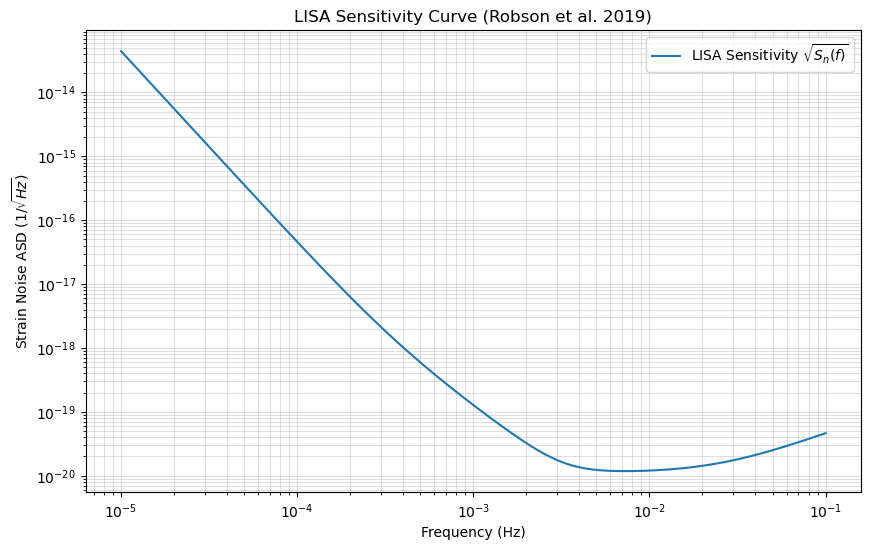

In [ ]:
# ==========================================
# 测试示例 (可以直接运行)
# ==========================================
if __name__ == "__main__":
    
    dt=t_M_in[1]-t_M_in[0]
    f_samp = 1/dt  
    
    
   
    h1=h_plus
    
  

    h2 = h_plus+0.01*h_cross  # 加入一点 cross 模式作为扰动

    #计算 Mismatch
    try:
        mm = compute_mismatch(h1, h2, f_samp, optimize_phase=True)
        print(f"Mismatch: {mm:.6e}")
        
        # 3. 绘制 PSD 检查一下灵敏度曲线是否正常
        freqs = np.logspace(-5, -1, 1000)
        sn = get_lisa_psd(freqs)
        
        plt.figure(figsize=(10, 6))
        plt.loglog(freqs, np.sqrt(sn), label='LISA Sensitivity $\\sqrt{S_n(f)}$')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Strain Noise ASD (1/$\\sqrt{Hz}$)')
        plt.title('LISA Sensitivity Curve (Robson et al. 2019)')
        plt.grid(True, which='both', alpha=0.4)
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"计算出错: {e}")